In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Loading and splitting the data
train_data = pd.read_csv('datasets/train.csv')

X = train_data.drop(columns=['A', 'B', 'C', 'D', 'E', 'Y'])  # Features (wavelengths 3800-7377)
y = train_data[['A', 'B', 'C', 'D', 'E', 'Y']]  # Targets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Preprocessing 
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_train_tensor = {target: torch.tensor(y_train[target].values, dtype=torch.float32).to(device) for target in ['A', 'B', 'C', 'D', 'E', 'Y']}
y_val_tensor = {target: torch.tensor(y_val[target].values, dtype=torch.float32).to(device) for target in ['A', 'B', 'C', 'D', 'E', 'Y']}

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim=6):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc1 = nn.Linear(128 * input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
models = {}
predictions = {}
EPOCH = 100

Training model for A...
MAPE for A: 0.13%


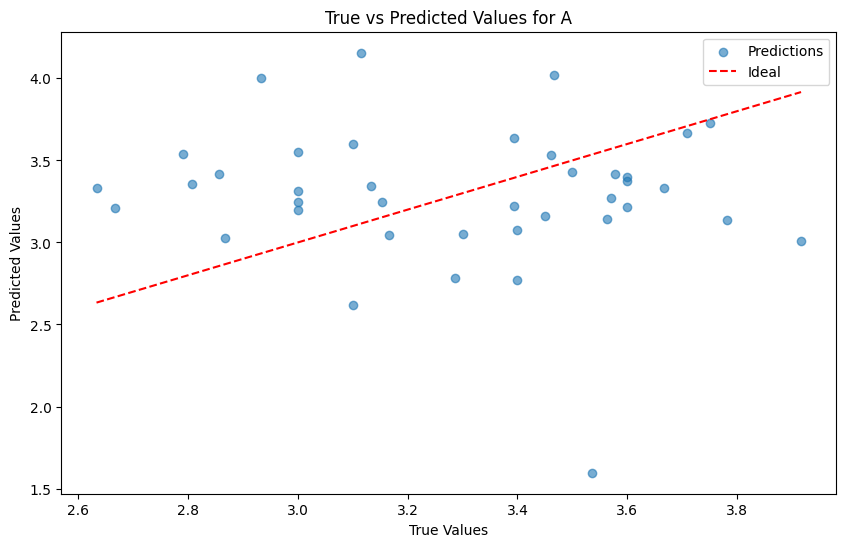

Training model for B...
MAPE for B: 0.09%


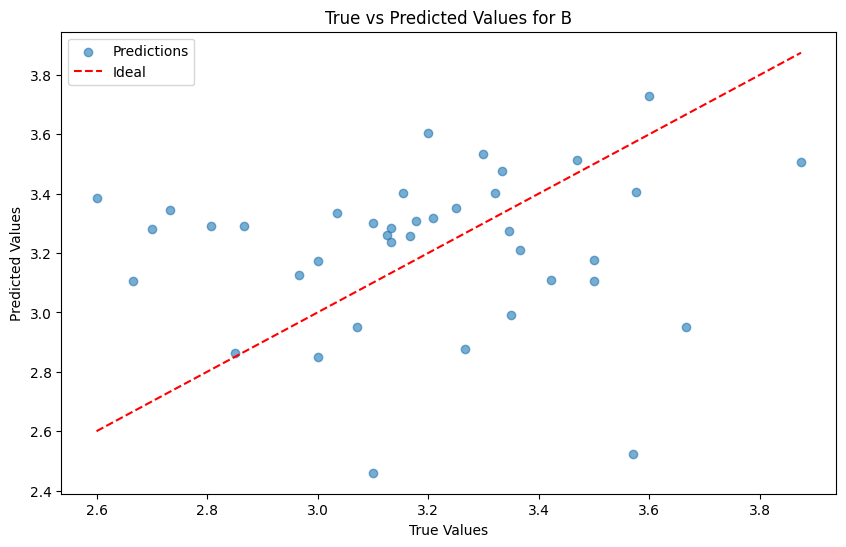

Training model for C...
MAPE for C: 0.08%


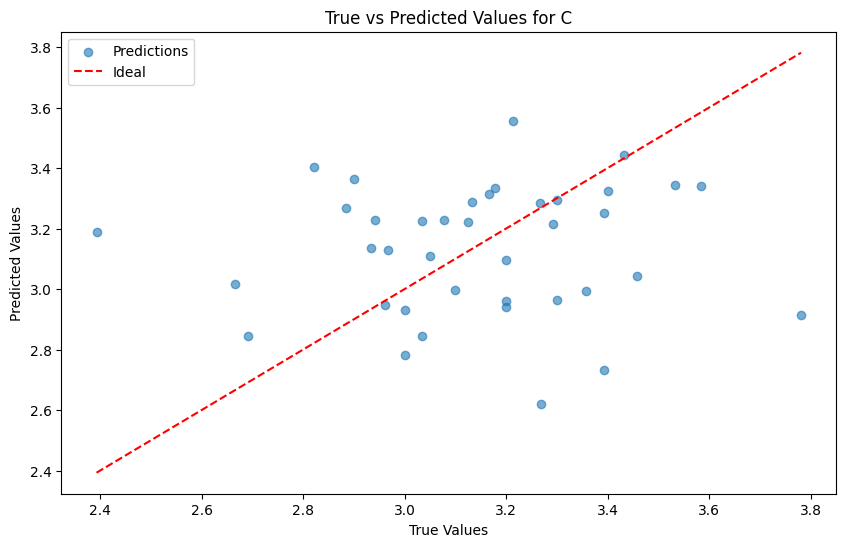

Training model for D...
MAPE for D: 0.14%


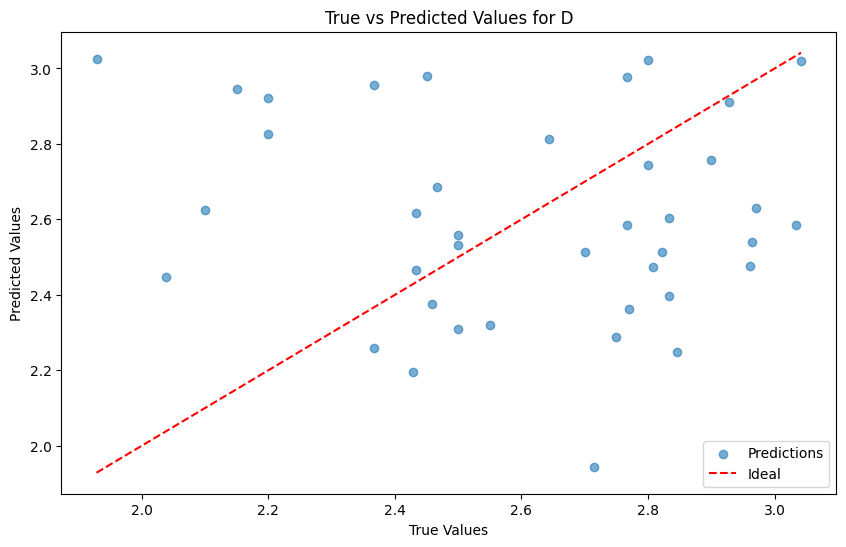

Training model for E...
MAPE for E: 0.20%


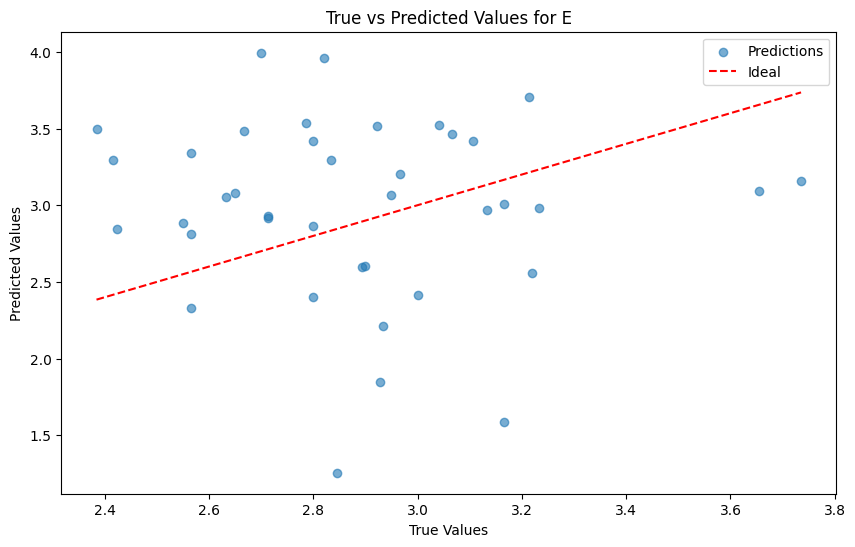

Training model for Y...
MAPE for Y: 0.07%


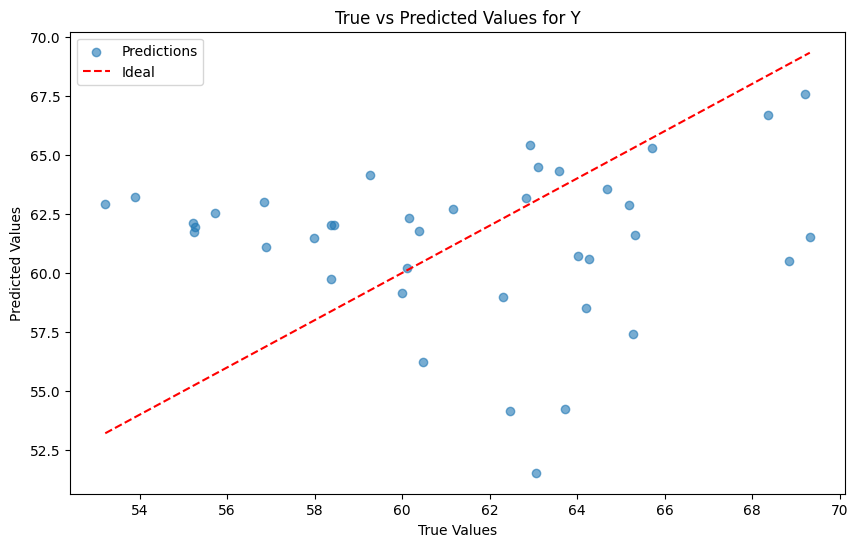

In [ ]:
for target in ['A', 'B', 'C', 'D', 'E', 'Y']:
    print(f"Training model for {target}...")
    
    model = CNNModel(X_train_tensor.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(EPOCH):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, torch.stack([y_train_tensor[target] for target in ['A', 'B', 'C', 'D', 'E', 'Y']], dim=1))
        loss.backward()
        optimizer.step()
    
    models[target] = model
    
    # Predicting on the validation set
    model.eval()
    with torch.no_grad():
        pred = model(X_val_tensor).cpu().numpy()
    predictions = {target: pred[:, i] for i, target in enumerate(['A', 'B', 'C', 'D', 'E', 'Y'])}
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_val[target].values, predictions[target])  # Convert y_val[target] to NumPy array
    print(f"MAPE for {target}: {mape:.2f}%")
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val[target].values, predictions[target], alpha=0.6, label='Predictions')  # Convert y_val[target] to NumPy array cause yes
    plt.plot([y_val[target].min(), y_val[target].max()], [y_val[target].min(), y_val[target].max()], 'r--', label='Ideal')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'True vs Predicted Values for {target}')
    plt.legend()
    plt.show()

In [8]:
prediction_df = pd.DataFrame(predictions)
print(prediction_df)

           A         B         C         D         E          Y
0   3.563481  3.397026  3.890079  2.313874  3.279866  65.415154
1   3.041741  3.198461  3.420091  2.418443  3.054938  54.138752
2   3.755989  3.419856  3.241437  2.685177  3.153128  65.283440
3   3.652671  2.961643  2.940928  2.655060  2.752639  61.623245
4   2.397936  2.665885  4.027083  1.931030  2.317461  56.224884
5   2.864995  3.744514  3.450148  2.406938  3.370284  61.517384
6   2.990378  3.534256  3.411886  2.565343  3.170521  61.934338
7   3.266384  3.150699  3.952720  2.535978  3.000470  59.161606
8   3.964777  3.551100  3.531403  2.712610  3.131247  66.671257
9   3.172018  3.470833  3.585540  2.773547  2.853441  62.117569
10  1.724746  3.514834  2.415608  2.508920  3.147300  60.724236
11  3.084916  3.028810  3.025661  2.624077  2.863319  63.201019
12  2.038403  3.194366  2.591842  2.683815  2.800761  60.570015
13  3.376704  3.561751  3.482434  2.852367  2.958684  62.877777
14  3.625118  3.350403  3.201691  2.8856